# Background
We, ACME, develop innovative artificial intelligence and computer vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

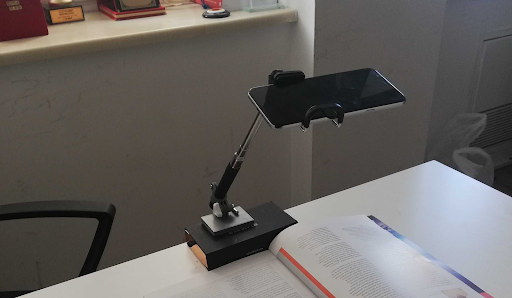

MonReader is a new mobile document digitalization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.


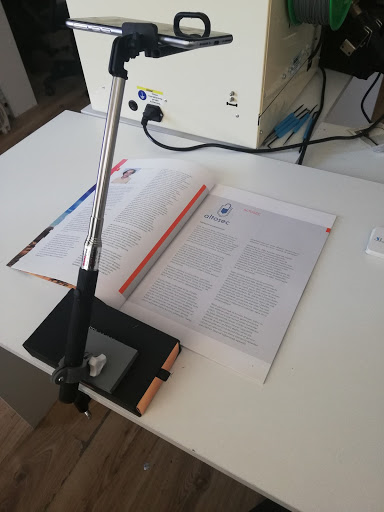

# Data Description:

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

# Download Data:
https://drive.google.com/file/d/1KDQBTbo5deKGCdVV_xIujscn5ImxW4dm/view?usp=sharing

# Goal(s):

Predict if the page is being flipped using a single image.

# Success Metrics:

Evaluate model performance based on F1 score, the higher the better.

# Bonus(es):

Predict if a given sequence of images contains an action of flipping.
# Submission Instructions:
Project should be implemented with Python
Please name your repository on GitHub with this name without exposing your project information: w9leg4Wi6WdxjG5W

# Plan
- crop image from the top
- use a pre-trained EfficientNet CNN model with the data we have from scratch (no weight at all)
- load a pre-trained EfficientNet model and finetune on the data we have 
- Experment with 3D CNN 
- Experment with Convolutional Recurrent Neural Networks 
- Use pytorch


In [ ]:
import os
import numpy as np 
import matplotlib.pyplot as plt 
import torch.nn.functional as F 
import torch 
from tqdm.notebook import tqdm

In [2]:
# add explainer notes 

def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['flip', 'notflip']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [20]:
# configuration

class CFG:
    epochs =20                              # No. of epochs for training the model
    lr = 0.001                              # Learning rate
    batch_size = 16                         # Batch Size for Dataset
    model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
    img_size = 224                          # Resize all the images to be 224 by 224
    
    # going to be used for loading dataset
    train_path ='datasets/monreader/training'
    validate_path='datasets/monreader/validation'
    test_path='datasets/monreader/testing'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cpu


In [10]:
from torchvision import transforms as T,datasets

train_transform = T.Compose([
                             #T.functional.crop(torch.Tensor, 1920/2, 1080/2, 1920, 1080), # Crop towards the right top corner, where the fliping activity happening.
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

validate_transform = T.Compose([
                             #T.functional.crop(torch.Tensor, 1920/2, 1080/2, 1920, 1080), # Crop towards the right top corner, where the fliping activity happening.
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = T.Compose([
                             #T.functional.crop(torch.Tensor, 1920/2, 1080/2, 1920, 1080), # Crop towards the right top corner, where the fliping activity happening.
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [11]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform)
print("Trainset Size:  {}".format(len(trainset)))

Trainset Size:  2152


In [12]:
validateset=datasets.ImageFolder(CFG.validate_path,transform=validate_transform)
print("validateset Size:  {}".format(len(validateset)))

validateset Size:  239


In [13]:

testset=datasets.ImageFolder(CFG.test_path,transform=test_transform)
print("testset Size:  {}".format(len(testset)))

testset Size:  598


In [37]:
trainset

Dataset ImageFolder
    Number of datapoints: 2152
    Root location: datasets/monreader/training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=(-20, 20), resample=False, expand=False)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

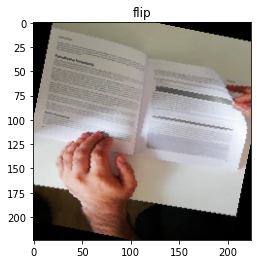

In [14]:
img,label = trainset[20]
#print(trainset.class_to_idx)

class_name =['flip', 'notflip']
show_image(img,class_name[label])
# randomly rotated

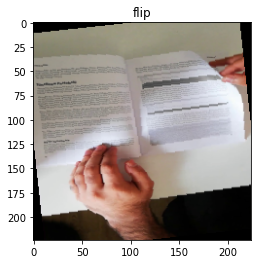

In [15]:
img,label = trainset[20]
#print(trainset.class_to_idx)

class_name =['flip', 'notflip']
show_image(img,class_name[label]) 

# randomly rotated

In [16]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


trainloader = DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:135
No. of Total examples:2152
No. of batches in validationloader:15
No. of Total examples:239
No. of batches in testloader:38
No. of Total examples:598


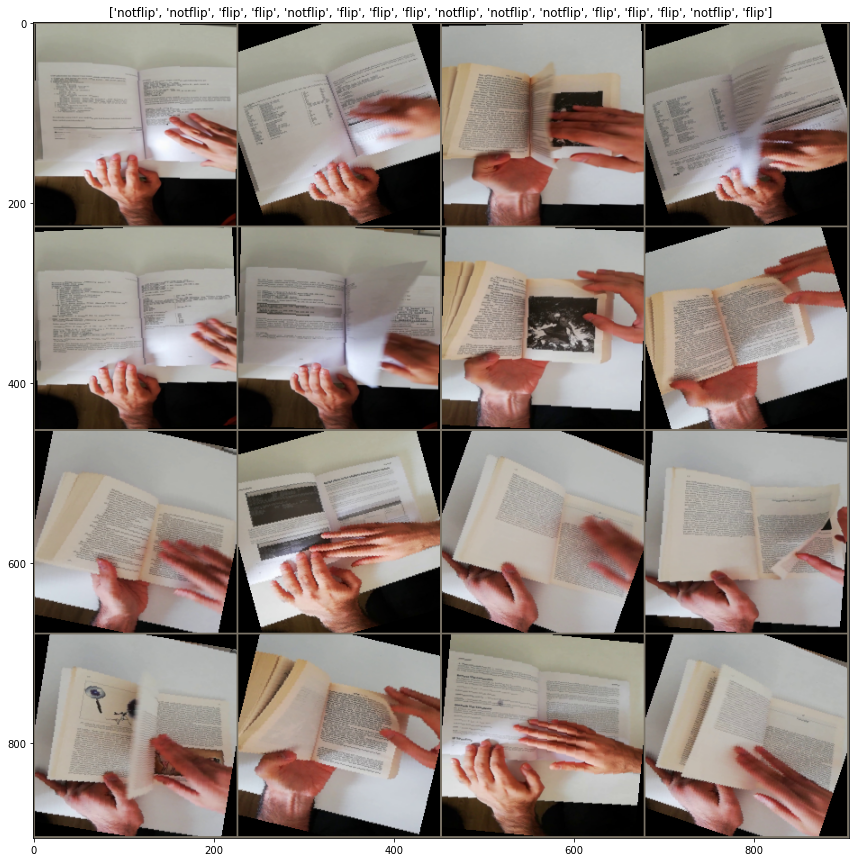

In [17]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

out = make_grid(images,nrow=4)

show_grid(out,title = [class_name[x] for x in labels])

In [19]:
!pip install timm # install PyTorch Image Models

In [21]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model(CFG.model_name,pretrained=True) #load pretrained model
model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to C:\Users\abebu/.cache\torch\hub\checkpoints\tf_efficientnet_b4_ns-d6313a46.pth


EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableCon

In [22]:
#let's update the pretarined model:
for param in model.parameters():
  param.requires_grad=False

#orginally, it was:
#(classifier): Linear(in_features=1792, out_features=1000, bias=True)


#we are updating it as a 2-class classifier:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

model

# after updatingnow it becomes:
#(classifier): Sequential(
#    (0): Linear(in_features=1792, out_features=625, bias=True)
#    (1): ReLU()
#    (2): Dropout(p=0.3, inplace=False)
#    (3): Linear(in_features=625, out_features=256, bias=True)
#    (4): ReLU()
#    (5): Linear(in_features=256, out_features=2, bias=True)
#  )

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableCon

In [24]:
!pip install torchsummary

In [25]:
from torchsummary import  summary
model.to(device) # move the model to GPU
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
           SwishMe-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
           SwishMe-6         [-1, 48, 112, 112]               0
            Conv2d-7             [-1, 12, 1, 1]             588
           SwishMe-8             [-1, 12, 1, 1]               0
            Conv2d-9             [-1, 48, 1, 1]             624
          Sigmoid-10             [-1, 48, 1, 1]               0
    SqueezeExcite-11         [-1, 48, 112, 112]               0
           Conv2d-12         [-1, 24, 112, 112]           1,152
      BatchNorm2d-13         [-1, 24, 112, 112]              48
         Identity-14         [-1, 24, 1

In [26]:
class MonReaderTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'MonReaderModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [27]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = MonReaderTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = CFG.epochs)


Valid_loss decreased inf --> 0.5176339666048686
Epoch : 1 Train Loss : 0.503426 Train Acc : 0.742593
Epoch : 1 Valid Loss : 0.517634 Valid Acc : 0.777778



Valid_loss decreased 0.5176339666048686 --> 0.4323767513036728
Epoch : 2 Train Loss : 0.402521 Train Acc : 0.811111
Epoch : 2 Valid Loss : 0.432377 Valid Acc : 0.770000



Valid_loss decreased 0.4323767513036728 --> 0.4231127331654231
Epoch : 3 Train Loss : 0.366466 Train Acc : 0.841204
Epoch : 3 Valid Loss : 0.423113 Valid Acc : 0.828056



Valid_loss decreased 0.4231127331654231 --> 0.4059434771537781
Epoch : 4 Train Loss : 0.343457 Train Acc : 0.853241
Epoch : 4 Valid Loss : 0.405943 Valid Acc : 0.836667



Valid_loss decreased 0.4059434771537781 --> 0.3935348113377889
Epoch : 5 Train Loss : 0.344749 Train Acc : 0.854167
Epoch : 5 Valid Loss : 0.393535 Valid Acc : 0.824722



Valid_loss decreased 0.3935348113377889 --> 0.31475094755490624
Epoch : 6 Train Loss : 0.277145 Train Acc : 0.888889
Epoch : 6 Valid Loss : 0.314751 Valid Acc : 0.861667



Epoch : 7 Train Loss : 0.295207 Train Acc : 0.878241
Epoch : 7 Valid Loss : 0.377652 Valid Acc : 0.849167



Epoch : 8 Train Loss : 0.274444 Train Acc : 0.887500
Epoch : 8 Valid Loss : 0.317630 Valid Acc : 0.833056



Valid_loss decreased 0.31475094755490624 --> 0.3145740841825803
Epoch : 9 Train Loss : 0.282814 Train Acc : 0.879630
Epoch : 9 Valid Loss : 0.314574 Valid Acc : 0.857778



Epoch : 10 Train Loss : 0.227599 Train Acc : 0.910648
Epoch : 10 Valid Loss : 0.338808 Valid Acc : 0.840833



Valid_loss decreased 0.3145740841825803 --> 0.30482458670934043
Epoch : 11 Train Loss : 0.242836 Train Acc : 0.896759
Epoch : 11 Valid Loss : 0.304825 Valid Acc : 0.870556



Valid_loss decreased 0.30482458670934043 --> 0.2765208601951599
Epoch : 12 Train Loss : 0.237554 Train Acc : 0.904167
Epoch : 12 Valid Loss : 0.276521 Valid Acc : 0.883056



Epoch : 13 Train Loss : 0.214596 Train Acc : 0.911111
Epoch : 13 Valid Loss : 0.280378 Valid Acc : 0.878889



Valid_loss decreased 0.2765208601951599 --> 0.26710419009129205
Epoch : 14 Train Loss : 0.216915 Train Acc : 0.914815
Epoch : 14 Valid Loss : 0.267104 Valid Acc : 0.895000



Valid_loss decreased 0.26710419009129205 --> 0.24483546763658523
Epoch : 15 Train Loss : 0.190729 Train Acc : 0.926852
Epoch : 15 Valid Loss : 0.244835 Valid Acc : 0.895278



Valid_loss decreased 0.24483546763658523 --> 0.21264196336269378
Epoch : 16 Train Loss : 0.248369 Train Acc : 0.903241
Epoch : 16 Valid Loss : 0.212642 Valid Acc : 0.920833



Valid_loss decreased 0.21264196336269378 --> 0.20935091214875381
Epoch : 17 Train Loss : 0.198944 Train Acc : 0.922685
Epoch : 17 Valid Loss : 0.209351 Valid Acc : 0.916111



Epoch : 18 Train Loss : 0.192303 Train Acc : 0.920370
Epoch : 18 Valid Loss : 0.238533 Valid Acc : 0.899722



Epoch : 19 Train Loss : 0.213370 Train Acc : 0.907407
Epoch : 19 Valid Loss : 0.264631 Valid Acc : 0.895556



Valid_loss decreased 0.20935091214875381 --> 0.19502571026484172
Epoch : 20 Train Loss : 0.199831 Train Acc : 0.910648
Epoch : 20 Valid Loss : 0.195026 Valid Acc : 0.908056


In [31]:
model.load_state_dict(torch.load('MonReaderModel.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)

print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))



Test Loss : 0.23229462633791723
Test Acc : 0.9051534533500671


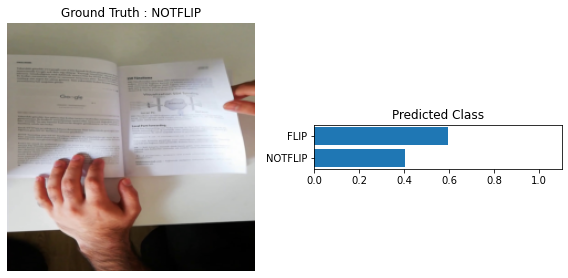

In [32]:

import torch.nn.functional as F

image,label = testset[15]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

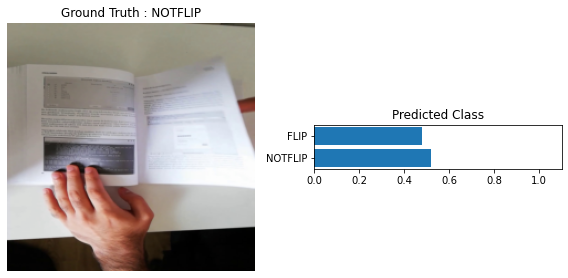

In [33]:
image,label = testset[5]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

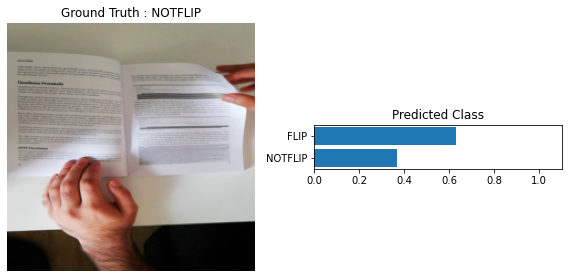

In [34]:
import torch.nn.functional as F

image,label = testset[10]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

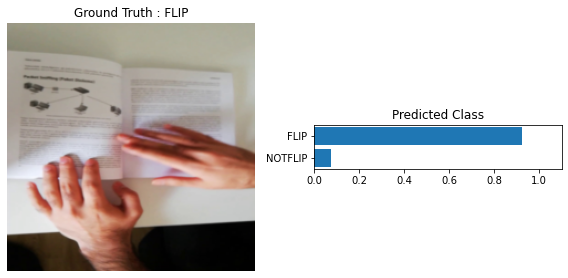

In [35]:
image,label = testset[324]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

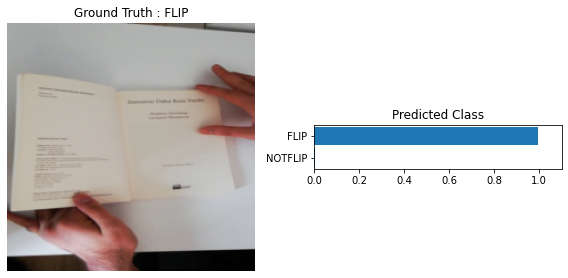

In [36]:
image,label = testset[450]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

## Next Steps
- Move forward with interpretability - implement the Grad CAM approach using Pytorch. https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57